In [35]:
import numpy as np
from sympy.logic import SOPform, boolalg
from sympy import symbols, srepr, Not
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [47]:
class BoolFunc():
    def __init__(self, params=[], n=3, param_type=0):
        self.n = n   # input size
        self.param_type = param_type
        self.assign_params(params)
            
    def relu(self, x):
        return x * (x>0)
    
    def get_params(self):
        return [self.W1, self.b1, self.W2, self.b2]
    
    def get_param_type(self):
        return self.param_type
    
    def change_param_type(self, x):
        if x >= 4:
            raise Exception('param_type must be a number between 0 and 3.')
        self.param_type = x
        self.assign_params()
        print(f'Neural network changed to type {x}')
    
    def forward(self, x):
        x = self.W1@x + self.b1
        x = self.relu(x)
        x = self.W2@x + self.b2
        x = self.relu(x)
        return x
    
    def update_D(self):
        if self.param_type == 0:
            raise Exception('Not supported yet')
        
        if self.param_type == 1:    
            logic_expr = self.get_SOP()
            force = False if self.n < 8 else True
            logic_expr_conj = boolalg.to_dnf(Not(logic_expr), simplify=True, force=force)
            str_le = srepr(logic_expr)
            str_le_conj = srepr(logic_expr_conj)
            
            # Find number of literals in both expression
            num_lit = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape('Symbol'), str_le))
            num_lit_conj = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape('Symbol'), str_le_conj))
        
            if num_lit < num_lit_conj:
                self.D = num_lit
            else:
                selfD = num_lit_conj
        
            self.D = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape('Symbol'), str_le)) + self.b2  # number of literals plus value of b2
        
        if self.param_type == 2:
            raise Exception('Not supported yet')
        
        if self.param_type == 3:    
            logic_expr = self.get_SOP()
            force = False if self.n < 8 else True
            logic_expr_conj = boolalg.to_dnf(Not(logic_expr), simplify=True, force=force)
            str_le = srepr(logic_expr)
            str_le_conj = srepr(logic_expr_conj)
            
            # Find number of literals in both expression
            num_lit = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape('Symbol'), str_le))
            num_lit_conj = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape('Symbol'), str_le_conj))
            
            # Choose the expression that minimises the number of literals
            if num_lit < num_lit_conj:
                if logic_expr == True or logic_expr == False:
                    self.D = 0

                elif not isinstance(logic_expr, boolalg.Or):
                    num_clau = 1
                    self.D = num_clau + num_lit

                else:
                    num_clau = len(logic_expr.args)   # number of clauses
                    self.D = num_clau + num_lit
            else:
                if logic_expr_conj == True or logic_expr_conj == False:
                    self.D = 0

                elif not isinstance(logic_expr_conj, boolalg.Or):
                    num_clau_conj = 1
                    self.D = num_clau_conj + num_lit_conj

                else:
                    num_clau_conj = len(logic_expr_conj.args)   # number of clauses
                    self.D = num_clau_conj + num_lit_conj
        
    def get_D(self):
        return self.D
    
    def get_SOP(self):
        if self.param_type == 0:
            raise Exception('Not supported yet.')
        
        if self.param_type == 1 or self.param_type == 2 or self.param_type == 3:
            sym = ''
            for i in range(self.n):
                sym = sym+str(i)+' '
            sym_list = list(symbols(sym))

            minterms = []
            for i in range(2**(self.n-1)):
                if ((-1 in self.W1[i,:]) or (1 in self.W1[i,:])) and self.W2[0,i] != 0:
                    minterms.append({})
                    for j in range(self.n):
                        if self.W1[i,j] == 1:
                            minterms[-1][sym_list[j]] = 1
                        elif self.W1[i,j] == -1:
                            minterms[-1][sym_list[j]] = 0
                        else:
                            pass

            if self.b2 == 0:
                return SOPform(sym_list, minterms)
            elif self.b2 == 1:
                force = False if self.n < 8 else True
                return boolalg.to_dnf(Not(SOPform(sym_list, minterms)), simplify=True, force=force)
            else:
                raise Exception('b2 has no valid value, must be 0 or 1.')
            
                            
    
    def assign_params(self, params=[]):
        if self.param_type == 0:
            if len(params) != 4:
                raise Exception('Invalid list of hyperparameters. Must have 2 weight matrices and 2 bias terms')
            elif len(params) == 0:
                raise Exception('No hyperparameters given in argument.')
            self.W1 = np.array(params[0])
            self.b1 = np.array(params[1])
            self.W2 = np.array(params[2])
            self.b2 = np.array(params[3])
            self.update_SOP_and_D()
    
        if self.param_type == 1:
            self.W1 = np.random.randint(-1, 2, size=(2**(self.n-1), self.n))
            
            self.b1 = np.zeros((2**(self.n-1),1), dtype=int)
            for i in range(2**(self.n-1)):
                if (-1 in self.W1[i,:]) or (1 in self.W1[i,:]):
                    freq_1 = 0
                    for j in self.W1[i,:]:
                        if j == 1:
                            freq_1 += 1
                    self.b1[i,0] = 1 - freq_1
                else:
                    self.b1[i,0] = 0
                
            self.W2 = np.zeros((1,2**(self.n-1)), dtype=int)
            self.b2 = 0
            if np.random.rand() > 0.5:
                for i in range(2**(self.n-1)):
                    self.W2[0,i] = (-1 in self.W1[i,:]) or (1 in self.W1[i,:])
            else:
                for i in range(2**(self.n-1)):
                    self.W2[0,i] = -1 * ((-1 in self.W1[i,:]) or (1 in self.W1[i,:]))
                self.b2 = 1
            
            self.update_D()
            
            
        if self.param_type == 2:
            self.W1 = np.random.randint(-1, 2, size=(2**(self.n-1), self.n))
            
            self.b1 = np.zeros((2**(self.n-1),1), dtype=int)
            for i in range(2**(self.n-1)):
                if (-1 in self.W1[i,:]) or (1 in self.W1[i,:]):
                    freq_1 = 0
                    for j in self.W1[i,:]:
                        if j == 1:
                            freq_1 += 1
                    self.b1[i,0] = 1 - freq_1
                else:
                    self.b1[i,0] = 0
                
            self.W2 = np.random.randint(-1, 2, (1,2**(self.n-1)))
            
            self.b2 = 0
            if np.random.rand() > 0.5:
                pass
            else:
                self.b2 = 1
            
            self.update_D()
            
        if self.param_type == 3:
            self.W1 = np.random.randint(-1, 2, size=(2**(self.n-1), self.n))
            
            self.b1 = np.zeros((2**(self.n-1),1), dtype=int)
            for i in range(2**(self.n-1)):
                if (-1 in self.W1[i,:]) or (1 in self.W1[i,:]):
                    freq_1 = 0
                    for j in self.W1[i,:]:
                        if j == 1:
                            freq_1 += 1
                    self.b1[i,0] = 1 - freq_1
                else:
                    self.b1[i,0] = 0
                
            self.W2 = np.random.randint(0, 2, (1,2**(self.n-1)))
            self.b2 = 0
            
            if np.random.rand() > 0.5:
                pass
            else:
                self.W2 = -self.W2
                self.b2 = 1
                
            self.update_D()

In [48]:
funca = BoolFunc(param_type=3)

print(funca.get_D())
print(funca.get_params())
print(funca.get_SOP())

0
[array([[ 0,  0,  1],
       [-1, -1, -1],
       [ 1,  1,  0],
       [ 0, -1, -1]]), array([[ 0],
       [ 1],
       [-1],
       [ 1]]), array([[0, 0, 0, 0]]), 0]
False


In [49]:
boolalg.to_dnf(funca.get_SOP(), simplify=True)

False

In [55]:
freq_dict = {}
for i in tqdm(range(10000)):
    func = BoolFunc(n=3, param_type=3)
    count = 0
    SOP = func.get_SOP()
    if SOP == True or SOP == False or not isinstance(SOP, boolalg.Or):      # accounts for SOPs with just one literal for which equals() function seems to fail.
        for key in freq_dict:
            if func.get_SOP() == key:
                freq_dict[key][0] += 1
                count += 1
                break
    else:
        for key in freq_dict:
            if func.get_SOP().equals(key):
                freq_dict[key][0] += 1
                count += 1
                break
    if count == 0:
        freq_dict[SOP] = [1, func.get_D()]
        



100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [35:40<00:00,  4.67it/s]


In [56]:
P = []
D = []
for key in freq_dict:
    P.append(freq_dict[key][0]/10000)
    D.append(freq_dict[key][1])

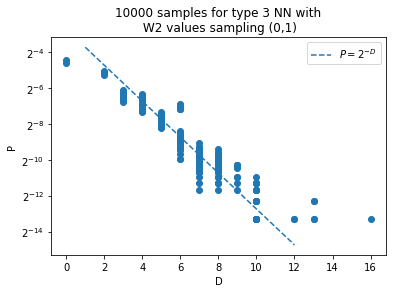

In [66]:
x = np.linspace(1,12, 100)
y = 0.15*2**(-x)

plt.scatter(D, P)
plt.plot(x,y, linestyle='--', label='$P=2^{-D}$')
plt.yscale('log', base=2)
plt.title('10000 samples for type 3 NN with\n W2 values sampling (0,1)')
plt.xlabel('D')
plt.ylabel('P')
plt.legend()
plt.savefig('P_vs_D_sampling_0_1_W2.png')

In [564]:
freq_dict
            

{~(2 | (1 & ~0)): [11, 5],
 ~(2 | ~0 | ~1): [20, 4],
 ~(0 | ~1 | ~2): [23, 4],
 ~((0 & ~2) | (2 & ~0 & ~1)): [1, 7],
 ~(~1 | (0 & 2)): [7, 5],
 ~((1 & ~2) | (2 & ~0)): [3, 6],
 ~(2 | (0 & ~1)): [10, 5],
 ~(2 | ~1): [16, 3],
 ~0: [11, 2],
 0: [20, 2],
 ~(0 | 1 | ~2): [20, 4],
 ~(~0 | ~1): [17, 3],
 ~(2 | (0 & ~1) | (1 & ~0)): [2, 8],
 ~(0 | ~2): [11, 3],
 (1 & 2) | (0 & ~2): [1, 6],
 True: [55, 0],
 ~0 | ~2: [9, 3],
 ~(2 | (0 & 1)): [6, 5],
 (2 & ~0) | (~0 & ~1) | (0 & 1 & ~2): [1, 10],
 0 | 2: [15, 3],
 ~(0 | ~1): [13, 3],
 ~(0 | 1 | 2): [24, 4],
 2 | (1 & ~0): [9, 5],
 (1 & 2) | (1 & ~0) | (2 & ~0): [2, 9],
 ~(0 | 2 | ~1): [14, 4],
 ~(~0 | (~1 & ~2)): [8, 5],
 (1 & 2) | (0 & ~1): [3, 6],
 ~(~0 | ~1 | ~2): [17, 4],
 2 | ~0: [18, 3],
 ~1 | (~0 & ~2): [5, 5],
 ~((2 & ~1) | (~0 & ~1)): [6, 5],
 ~(1 | ~0): [15, 3],
 0 | 1 | ~2: [15, 4],
 1 | 2 | ~0: [20, 4],
 ~2 | (0 & 1): [9, 5],
 ~((1 & 2) | (2 & ~0) | (0 & ~1 & ~2)): [4, 10],
 ~((0 & 2) | (~1 & ~2)): [4, 6],
 ~((1 & ~0) | (~1 & ~2)): [5

In [7]:
(3**(4*2**(2)))

3**16

43046721

In [ ]:
func.find_SOP().equals(symbols(''))

In [270]:
def clauses(expr):    # for DNFs only
    if not isinstance(expr, boolalg.Or):
        return expr
    return expr.args

In [272]:
clauses(funcb.find_SOP())

(~0, ~1, 0 & 2 & ~1, 1 & 2 & ~0)

In [277]:
len(funcb.find_SOP().args)

4

In [256]:
funca.find_SOP()

True

In [257]:
symbols('True')

True